In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime
from collections import Counter
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, Ridge, HuberRegressor, ARDRegression

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 400
from boruta import BorutaPy

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



TEST_PARAMS = {'boosting': 'gbdt', 'metric': 'rmse', 'n_jobs': -1, 'task': 'train', 'objective': 'regression', 'verbosity': -1,
                     'learning_rate': 0.013860391695841696, 'feature_fraction': 0.5125953288426656, 'num_leaves': 87, 
                     'min_data_in_leaf': 27, 'max_depth': 8, 'reg_alpha': 46.78603135204973, 'reg_lambda': 16.480638186141086,
                     'subsample': 0.8481917131995176, 'colsample_bytree': 0.7078246417672323, 'min_child_weight': 20, 
                     'min_split_gain': 20, 'bagging_freq': 6, 'bagging_fraction': 0.7621423801620405
                    }


# CV=3.642376443268109 when n_folds=4, hyperparameter tuned by optuna
STRATIFIED_PARAMS_0 = {'boosting': 'gbdt', 'metric': 'rmse', 'n_jobs': -1, 'task': 'train', 'objective': 'regression', 'verbosity': -1,
                     'learning_rate': 0.0013190418173159972, 'feature_fraction': 0.36297778017765725, 
                     'num_leaves': 89, 'min_data_in_leaf': 39, 'max_depth': 7, 'reg_alpha': 25.39105529977347, 
                     'reg_lambda': 29.58097109038505, 'subsample': 0.862369091812224, 'colsample_bytree': 0.5843638251759384,
                     'min_child_weight': 41, 'min_split_gain': 10, 'bagging_freq': 7, 'bagging_fraction': 0.885207681766811
                    }



# CV=3.6421812575005705 when n_folds=4, hyperparameter tuned by optuna
STRATIFIED_PARAMS_1 = {'boosting': 'gbdt', 'metric': 'rmse', 'n_jobs': -1, 'task': 'train', 'objective': 'regression', 'verbosity': -1,
                     'learning_rate': 0.0013860391695841696, 'feature_fraction': 0.5125953288426656, 'num_leaves': 87, 
                     'min_data_in_leaf': 27, 'max_depth': 8, 'reg_alpha': 46.78603135204973, 'reg_lambda': 16.480638186141086,
                     'subsample': 0.8481917131995176, 'colsample_bytree': 0.7078246417672323, 'min_child_weight': 20, 
                     'min_split_gain': 20, 'bagging_freq': 6, 'bagging_fraction': 0.7621423801620405
                    }


# CV=3.6427012031674 when n_folds=4, hyperparameter tuned by optuna
REPEATED_PARAMS_0 = { 'boosting': 'gbdt', 'metric': 'rmse', 'n_jobs': -1, 'task': 'train', 'objective': 'regression', 'verbosity': -1,
                    'learning_rate': 0.0010712015028592624, 'feature_fraction': 0.5052382649156922,
                    'num_leaves': 64, 'min_data_in_leaf': 23, 'max_depth': 7, 'reg_alpha': 29.15343652246633,
                    'reg_lambda': 21.458786989016055, 'subsample': 0.7990716119903709, 'colsample_bytree': 0.7828710415834845, 
                    'min_child_weight': 31, 'min_split_gain': 10, 'bagging_freq': 9, 'bagging_fraction': 0.6205776338837947
                 }

# CV=3.6426227065514714
REPEATED_PARAMS_1 = {'boosting': 'gbdt', 'metric': 'rmse', 'n_jobs': -1, 'task': 'train', 'objective': 'regression', 'verbosity': -1,
                   'learning_rate': 0.0014598258225412568, 'feature_fraction': 0.43333719560435124, 'num_leaves': 67, 'min_data_in_leaf': 31,
                   'max_depth': 7, 'reg_alpha': 46.10350437019562, 'reg_lambda': 14.84571014702843, 'subsample': 0.983608472054762,
                   'colsample_bytree': 0.6725689540145747, 'min_child_weight': 49, 'min_split_gain': 13, 'bagging_freq': 10, 'bagging_fraction': 0.8456214358772184
                    }


FEATS_EXCLUDED = ['target', 'card_id', 'outliers', 'first_active_month',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0', 'hist_purchase_date_ptp', 'new_purchase_date_ptp'
                 ]

def kfold_lightgbm(train_df, test_df, num_folds=11, params=STRATIFIED_PARAMS_0, stratified=True, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    categorical_features = ['feature_1_orig', 'feature_2_orig', 'feature_3_orig',
                            #'first_active_year', 
                            #'first_active_month_month', 'first_active_quarter'
                           ]
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
    else:
        folds = RepeatedKFold(n_splits=num_folds, n_repeats=1, random_state=326)
    
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]
        
        print('Fold {} begins....'.format(n_fold+1))
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                categorical_feature=categorical_features)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               categorical_feature=categorical_features)
        
        model = lgb.train(params, lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'test'],
                          num_boost_round=20000,
                          early_stopping_rounds= 500,
                          verbose_eval=100)
        
        oof_preds[valid_idx] = model.predict(train_df.iloc[valid_idx][feats], num_iteration=model.best_iteration)
        sub_preds += model.predict(test_df[feats], num_iteration=model.best_iteration) / num_folds
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold+1, rmse(valid_y, oof_preds[valid_idx])))
        
        del model, train_x, train_y, valid_x, valid_y, train_idx, valid_idx
        gc.collect()
        
    RMSE = rmse(oof_preds, train_df['target'])
    print('RMSE is: {}'.format(RMSE))
    return oof_preds, sub_preds, feature_importance_df

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(12, 50))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    return best_features.sort_values(by="importance", ascending=False)

    

In [11]:
corr = train_df.corr()

In [16]:
corr[['outliers']].sort_values('outliers')

,outliers
target,-0.896187
hist_purchase_date_max,-0.080023
new_month_lag_max,-0.074103
new_Time,-0.071969
new_purchase_date_month_nunique,-0.070646
new_month_lag_tquartile,-0.069195
new_month_lag_Range,-0.065642
new_purchase_date_day_max,-0.065184
hist_purchase_date_min,-0.064985
new_purchase_date_weekofyear_nunique,-0.064074


In [45]:
corr.head()

,level_0,feature_1,feature_2,feature_3,outliers,target,first_active_year,first_active_quarter,first_active_month_month,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_1_orig,feature_2_orig,feature_3_orig,hist_card_id_size,hist_card_id_count,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_fquartile,hist_purchase_amount_median,hist_purchase_amount_tquartile,hist_purchase_amount_var,hist_purchase_amount_Range,hist_log_purchase_amount_mean,hist_price_sum,hist_price_mean,hist_price_fquartile,hist_price_median,hist_price_tquartile,hist_price_max,hist_price_min,hist_price_var,hist_duration_sum,hist_duration_mean,hist_duration_fquartile,hist_duration_median,hist_duration_tquartile,hist_duration_max,hist_duration_min,hist_duration_var,hist_duration_Range,hist_amount_month_ratio_sum,hist_amount_month_ratio_mean,hist_amount_month_ratio_fquartile,hist_amount_month_ratio_median,hist_amount_month_ratio_tquartile,hist_amount_month_ratio_max,hist_amount_month_ratio_min,hist_amount_month_ratio_var,hist_amount_month_ratio_Range,hist_installments_sum,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_lag_median,hist_month_lag_fquartile,hist_month_lag_tquartile,hist_month_lag_Range,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_month_diff_median,hist_month_diff_fquartile,hist_month_diff_tquartile,hist_authorized_flag_mean,hist_numerical_1_sum,hist_numerical_1_mean,hist_numerical_1_fquartile,hist_numerical_1_median,hist_numerical_1_max,hist_numerical_1_min,hist_numerical_1_var,hist_numerical_2_sum,hist_numerical_2_mean,hist_numerical_2_fquartile,hist_numerical_2_median,hist_numerical_2_max,hist_numerical_2_min,hist_numerical_2_var,hist_numerical_diff_mean,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_purchase_date_month_nunique,hist_purchase_date_month_mean,hist_purchase_date_month_min,hist_purchase_date_month_max,hist_purchase_date_hour_nunique,hist_purchase_date_hour_mean,hist_purchase_date_hour_min,hist_purchase_date_hour_max,hist_purchase_date_weekofyear_nunique,hist_purchase_date_weekofyear_mean,hist_purchase_date_weekofyear_min,hist_purchase_date_weekofyear_max,hist_purchase_date_weekday_nunique,hist_purchase_date_weekday_mean,hist_purchase_date_weekday_min,hist_purchase_date_weekday_max,hist_purchase_date_day_nunique,hist_purchase_date_day_mean,hist_purchase_date_day_min,hist_purchase_date_day_max,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_mean,hist_category_1_x_mean,hist_category_1_y_mean,hist_category_2_x_mean,hist_category_2_y_mean,hist_category_3_mean,hist_category_4_mean,hist_category_2_x_mean_mean,hist_category_3_mean_mean,new_card_id_size,new_card_id_count,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_fquartile,new_purchase_amount_median,new_purchase_amount_tquartile,new_purchase_amount_var,new_purchase_amount_Range,new_log_purchase_amount_mean,new_price_sum,new_price_mean,new_price_fquartile,new_price_median,new_price_tquartile,new_price_max,new_price_min,new_price_var,new_duration_sum,new_duration_mean,new_duration_fquartile,new_duration_median,new_duration_tquartile,new_duration_max,new_duration_min,new_duration_var,new_duration_Range,new_amount_month_ratio_sum,new_amount_month_ratio_mean,new_amount_month_ratio_fquartile,new_amount_month_ratio_median,new_amount_month_ratio_tquartile,new_amount_month_ratio_max,new_amount_month_ratio_min,new_amount_month_ratio_var,new_amount_month_ratio_Range,new_installments_su

In [44]:
corr = corr.reset_index()
corr = corr.set_index('index')

In [ ]:
# Tried remove but resulted in worse CV:    
## var, skew makes very little difference
## AOV, log_purchase, _var, avg_sales, avg_purchase, hour(very important), category_1_y(important)
## all category_ have meanings, Predictive_CLV
## hist_purchase_amount_sum


In [153]:
# benchmark 3.6437164646350215
excl = []
#excl = [*corr.index[(corr['outliers']<=0.0026) & (corr['outliers']>=-0.00026)]]
for col in train_df.columns:
    if '_numerical' in col:        # good deletion, 3.6433101419244784
        excl.append(col)
    elif 'duration' in col:        # good deletion, 3.642940780909399
        excl.append(col)
    elif 'AOV' in col:
        if 'diff' not in col:
            if 'ratio' not in col:
                excl.append(col)
    elif '_CLV' in col:
        if 'diff' not in col:
            if 'ratio' not in col:
                excl.append(col)
    elif 'Monitary' in col:
        excl.append(col)
    elif 'Frequency' in col:
        if 'diff' not in col:
            if 'ratio' not in col:
                excl.append(col)  # good deletion,  3.6422579223056153
                
excl


['hist_duration_sum',
 'hist_duration_mean',
 'hist_duration_fquartile',
 'hist_duration_median',
 'hist_duration_tquartile',
 'hist_duration_max',
 'hist_duration_min',
 'hist_duration_var',
 'hist_duration_Range',
 'hist_numerical_1_sum',
 'hist_numerical_1_mean',
 'hist_numerical_1_fquartile',
 'hist_numerical_1_median',
 'hist_numerical_1_max',
 'hist_numerical_1_min',
 'hist_numerical_1_var',
 'hist_numerical_2_sum',
 'hist_numerical_2_mean',
 'hist_numerical_2_fquartile',
 'hist_numerical_2_median',
 'hist_numerical_2_max',
 'hist_numerical_2_min',
 'hist_numerical_2_var',
 'hist_numerical_diff_mean',
 'new_duration_sum',
 'new_duration_mean',
 'new_duration_fquartile',
 'new_duration_median',
 'new_duration_tquartile',
 'new_duration_max',
 'new_duration_min',
 'new_duration_var',
 'new_duration_Range',
 'new_numerical_1_sum',
 'new_numerical_1_mean',
 'new_numerical_1_fquartile',
 'new_numerical_1_median',
 'new_numerical_1_max',
 'new_numerical_1_min',
 'new_numerical_1_var',


In [155]:
#train_df.corr().sort_values('outliers', ascending=False)['outliers']



outliers                                 1.000000
hist_month_diff_median                   0.082719
hist_month_diff_mean                     0.082018
hist_month_diff_tquartile                0.081591
hist_month_diff_fquartile                0.081589
hist_month_diff_max                      0.081055
hist_month_diff_min                      0.080766
hist_Recency                             0.080012
Recency_diff                             0.055010
elapsed_time                             0.053738
hist_category_1_y_mean                   0.048236
hist_category_1_x_mean                   0.046921
days_feature1                            0.044923
hist_first_buy                           0.035870
days_feature2                            0.035465
hist_last_buy                            0.034357
hist_category_3_mean                     0.034034
new_purchase_date_weekofyear_min         0.031981
category_1_x_mean                        0.031952
hist_purchase_date_weekofyear_min        0.031382


In [157]:
_, _, _ = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1), num_folds=4, params=TEST_PARAMS)


Starting LightGBM. Train shape: (201917, 293), test shape: (123623, 293)
Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.59775	test's rmse: 3.6745
[200]	train's rmse: 3.49235	test's rmse: 3.64153
[300]	train's rmse: 3.42868	test's rmse: 3.63166
[400]	train's rmse: 3.37717	test's rmse: 3.62645
[500]	train's rmse: 3.33621	test's rmse: 3.62547
[600]	train's rmse: 3.29868	test's rmse: 3.62555
[700]	train's rmse: 3.26554	test's rmse: 3.6251
[800]	train's rmse: 3.23363	test's rmse: 3.62477
[900]	train's rmse: 3.20874	test's rmse: 3.62495
[1000]	train's rmse: 3.18484	test's rmse: 3.62528
[1100]	train's rmse: 3.16384	test's rmse: 3.62587
[1200]	train's rmse: 3.14479	test's rmse: 3.62622
Early stopping, best iteration is:
[733]	train's rmse: 3.25413	test's rmse: 3.62451
Fold  1 RMSE : 3.624507
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.58745	test's rmse: 3.69229
[200]	train's rmse:

In [159]:
train_df = pd.read_hdf('Elo_new.h5', 'train_df_CV_36435')
test_df = pd.read_hdf('Elo_new.h5', 'test_df_CV_36435')

In [160]:
%%time
#CV_0=3.640618226405863
#CV_0=3.64052874769853

## with drop excl:
#CV_0=3.6399623562218286
#CV=3.6397278653003435
oof_0, sub_0, _ = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1), params=STRATIFIED_PARAMS_0)
oof_1, sub_1, _ = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1), params=STRATIFIED_PARAMS_1)


Starting LightGBM. Train shape: (201917, 292), test shape: (123623, 292)
Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.81182	test's rmse: 3.81373
[200]	train's rmse: 3.77893	test's rmse: 3.78561
[300]	train's rmse: 3.75083	test's rmse: 3.76194
[400]	train's rmse: 3.72712	test's rmse: 3.74263
[500]	train's rmse: 3.70646	test's rmse: 3.72624
[600]	train's rmse: 3.68832	test's rmse: 3.71262
[700]	train's rmse: 3.67235	test's rmse: 3.70116
[800]	train's rmse: 3.65798	test's rmse: 3.69138
[900]	train's rmse: 3.64525	test's rmse: 3.68315
[1000]	train's rmse: 3.63347	test's rmse: 3.67598
[1100]	train's rmse: 3.6229	test's rmse: 3.66977
[1200]	train's rmse: 3.61308	test's rmse: 3.66436
[1300]	train's rmse: 3.60386	test's rmse: 3.65961
[1400]	train's rmse: 3.59521	test's rmse: 3.65539
[1500]	train's rmse: 3.58724	test's rmse: 3.65142
[1600]	train's rmse: 3.57971	test's rmse: 3.64816
[1700]	train's rmse: 3.57249	test's rmse: 3.64517
[1800]

[4800]	train's rmse: 3.43464	test's rmse: 3.6622
[4900]	train's rmse: 3.43139	test's rmse: 3.66211
[5000]	train's rmse: 3.42829	test's rmse: 3.66208
[5100]	train's rmse: 3.42506	test's rmse: 3.6622
[5200]	train's rmse: 3.42223	test's rmse: 3.66228
[5300]	train's rmse: 3.41936	test's rmse: 3.66217
[5400]	train's rmse: 3.41658	test's rmse: 3.66209
[5500]	train's rmse: 3.41361	test's rmse: 3.66207
[5600]	train's rmse: 3.41074	test's rmse: 3.66206
[5700]	train's rmse: 3.40795	test's rmse: 3.66196
[5800]	train's rmse: 3.40513	test's rmse: 3.66196
[5900]	train's rmse: 3.40236	test's rmse: 3.66185
[6000]	train's rmse: 3.39958	test's rmse: 3.66192
[6100]	train's rmse: 3.39692	test's rmse: 3.66199
[6200]	train's rmse: 3.39431	test's rmse: 3.662
[6300]	train's rmse: 3.39184	test's rmse: 3.66197
[6400]	train's rmse: 3.38914	test's rmse: 3.66203
Early stopping, best iteration is:
[5905]	train's rmse: 3.4022	test's rmse: 3.66183
Fold  4 RMSE : 3.661829
Fold 5 begins....
Training until validation sc

[700]	train's rmse: 3.67027	test's rmse: 3.71228
[800]	train's rmse: 3.65588	test's rmse: 3.70344
[900]	train's rmse: 3.64306	test's rmse: 3.69646
[1000]	train's rmse: 3.63126	test's rmse: 3.69038
[1100]	train's rmse: 3.62071	test's rmse: 3.68535
[1200]	train's rmse: 3.61089	test's rmse: 3.6808
[1300]	train's rmse: 3.6016	test's rmse: 3.67663
[1400]	train's rmse: 3.59303	test's rmse: 3.67322
[1500]	train's rmse: 3.58502	test's rmse: 3.67005
[1600]	train's rmse: 3.57737	test's rmse: 3.66725
[1700]	train's rmse: 3.56997	test's rmse: 3.66489
[1800]	train's rmse: 3.56327	test's rmse: 3.66264
[1900]	train's rmse: 3.5568	test's rmse: 3.66072
[2000]	train's rmse: 3.5506	test's rmse: 3.65918
[2100]	train's rmse: 3.5449	test's rmse: 3.65766
[2200]	train's rmse: 3.5393	test's rmse: 3.65655
[2300]	train's rmse: 3.53411	test's rmse: 3.6556
[2400]	train's rmse: 3.52916	test's rmse: 3.65453
[2500]	train's rmse: 3.52427	test's rmse: 3.65361
[2600]	train's rmse: 3.51961	test's rmse: 3.65273
[2700]	tra

[2100]	train's rmse: 3.49517	test's rmse: 3.64406
[2200]	train's rmse: 3.48857	test's rmse: 3.643
[2300]	train's rmse: 3.48203	test's rmse: 3.64221
[2400]	train's rmse: 3.47595	test's rmse: 3.64111
[2500]	train's rmse: 3.46983	test's rmse: 3.64021
[2600]	train's rmse: 3.46434	test's rmse: 3.63944
[2700]	train's rmse: 3.4586	test's rmse: 3.63874
[2800]	train's rmse: 3.45307	test's rmse: 3.63794
[2900]	train's rmse: 3.44802	test's rmse: 3.63742
[3000]	train's rmse: 3.44267	test's rmse: 3.63701
[3100]	train's rmse: 3.43757	test's rmse: 3.63658
[3200]	train's rmse: 3.43259	test's rmse: 3.636
[3300]	train's rmse: 3.42773	test's rmse: 3.63563
[3400]	train's rmse: 3.42295	test's rmse: 3.63535
[3500]	train's rmse: 3.4183	test's rmse: 3.63502
[3600]	train's rmse: 3.41368	test's rmse: 3.63479
[3700]	train's rmse: 3.40936	test's rmse: 3.63449
[3800]	train's rmse: 3.40494	test's rmse: 3.63423
[3900]	train's rmse: 3.40066	test's rmse: 3.63398
[4000]	train's rmse: 3.39628	test's rmse: 3.6337
[4100]	

[5000]	train's rmse: 3.35938	test's rmse: 3.63461
[5100]	train's rmse: 3.35616	test's rmse: 3.63455
[5200]	train's rmse: 3.35244	test's rmse: 3.63448
[5300]	train's rmse: 3.3492	test's rmse: 3.63434
[5400]	train's rmse: 3.3454	test's rmse: 3.63429
[5500]	train's rmse: 3.34162	test's rmse: 3.63427
[5600]	train's rmse: 3.33824	test's rmse: 3.63417
[5700]	train's rmse: 3.33486	test's rmse: 3.63427
[5800]	train's rmse: 3.33148	test's rmse: 3.63434
[5900]	train's rmse: 3.32797	test's rmse: 3.63425
[6000]	train's rmse: 3.32493	test's rmse: 3.63418
Early stopping, best iteration is:
[5563]	train's rmse: 3.33948	test's rmse: 3.63411
Fold  6 RMSE : 3.634114
Fold 7 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.80668	test's rmse: 3.80854
[200]	train's rmse: 3.76986	test's rmse: 3.77662
[300]	train's rmse: 3.73847	test's rmse: 3.75043
[400]	train's rmse: 3.71161	test's rmse: 3.72937
[500]	train's rmse: 3.68826	test's rmse: 3.71152
[600]	train's rms

[5400]	train's rmse: 3.33803	test's rmse: 3.67336
[5500]	train's rmse: 3.33454	test's rmse: 3.67335
Early stopping, best iteration is:
[5065]	train's rmse: 3.34981	test's rmse: 3.67318
Fold 11 RMSE : 3.673177
RMSE is: 3.6397278653003435
CPU times: user 16h 51min 13s, sys: 11min 21s, total: 17h 2min 35s
Wall time: 1h 31min 58s


In [161]:
%%time
# with drop
#CV=3.6407191020629592
#CV=3.640155332295008
oof_2, sub_2, _ = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1), params=REPEATED_PARAMS_0, stratified=False)
oof_3, sub_3, _ = kfold_lightgbm(train_df.drop(excl,axis=1), test_df.drop(excl,axis=1), params=REPEATED_PARAMS_1, stratified=False)


Starting LightGBM. Train shape: (201917, 292), test shape: (123623, 292)
Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.81472	test's rmse: 3.85587
[200]	train's rmse: 3.78655	test's rmse: 3.83149
[300]	train's rmse: 3.76226	test's rmse: 3.81083
[400]	train's rmse: 3.74109	test's rmse: 3.79375
[500]	train's rmse: 3.72242	test's rmse: 3.7787
[600]	train's rmse: 3.7062	test's rmse: 3.76647
[700]	train's rmse: 3.69132	test's rmse: 3.75547
[800]	train's rmse: 3.67783	test's rmse: 3.74605
[900]	train's rmse: 3.66583	test's rmse: 3.73778
[1000]	train's rmse: 3.65478	test's rmse: 3.73079
[1100]	train's rmse: 3.64486	test's rmse: 3.72467
[1200]	train's rmse: 3.63575	test's rmse: 3.71969
[1300]	train's rmse: 3.62703	test's rmse: 3.71458
[1400]	train's rmse: 3.61881	test's rmse: 3.71042
[1500]	train's rmse: 3.61105	test's rmse: 3.70672
[1600]	train's rmse: 3.60383	test's rmse: 3.70322
[1700]	train's rmse: 3.59702	test's rmse: 3.70026
[1800]	

[4400]	train's rmse: 3.47594	test's rmse: 3.77639
[4500]	train's rmse: 3.47298	test's rmse: 3.77623
[4600]	train's rmse: 3.46998	test's rmse: 3.77603
[4700]	train's rmse: 3.46725	test's rmse: 3.77598
[4800]	train's rmse: 3.46455	test's rmse: 3.77586
[4900]	train's rmse: 3.46174	test's rmse: 3.77575
[5000]	train's rmse: 3.45896	test's rmse: 3.77566
[5100]	train's rmse: 3.45621	test's rmse: 3.77556
[5200]	train's rmse: 3.45345	test's rmse: 3.77543
[5300]	train's rmse: 3.45067	test's rmse: 3.77528
[5400]	train's rmse: 3.44809	test's rmse: 3.77527
[5500]	train's rmse: 3.44536	test's rmse: 3.77519
[5600]	train's rmse: 3.44289	test's rmse: 3.77525
[5700]	train's rmse: 3.44027	test's rmse: 3.77523
[5800]	train's rmse: 3.43778	test's rmse: 3.77523
[5900]	train's rmse: 3.43526	test's rmse: 3.77518
Early stopping, best iteration is:
[5445]	train's rmse: 3.44679	test's rmse: 3.77515
Fold  4 RMSE : 3.775149
Fold 5 begins....
Training until validation scores don't improve for 500 rounds.
[100]	trai

[1700]	train's rmse: 3.61041	test's rmse: 3.56288
[1800]	train's rmse: 3.60409	test's rmse: 3.56053
[1900]	train's rmse: 3.59795	test's rmse: 3.55853
[2000]	train's rmse: 3.59206	test's rmse: 3.55646
[2100]	train's rmse: 3.58641	test's rmse: 3.55477
[2200]	train's rmse: 3.58108	test's rmse: 3.55342
[2300]	train's rmse: 3.57632	test's rmse: 3.55204
[2400]	train's rmse: 3.57189	test's rmse: 3.55098
[2500]	train's rmse: 3.5675	test's rmse: 3.54994
[2600]	train's rmse: 3.56318	test's rmse: 3.5489
[2700]	train's rmse: 3.55898	test's rmse: 3.5478
[2800]	train's rmse: 3.55514	test's rmse: 3.54702
[2900]	train's rmse: 3.55154	test's rmse: 3.54619
[3000]	train's rmse: 3.54772	test's rmse: 3.5454
[3100]	train's rmse: 3.54403	test's rmse: 3.54472
[3200]	train's rmse: 3.54043	test's rmse: 3.54414
[3300]	train's rmse: 3.5368	test's rmse: 3.54353
[3400]	train's rmse: 3.53322	test's rmse: 3.54294
[3500]	train's rmse: 3.52979	test's rmse: 3.54243
[3600]	train's rmse: 3.52665	test's rmse: 3.542
[3700]	

[2100]	train's rmse: 3.53768	test's rmse: 3.67926
[2200]	train's rmse: 3.53229	test's rmse: 3.67799
[2300]	train's rmse: 3.5276	test's rmse: 3.67691
[2400]	train's rmse: 3.52297	test's rmse: 3.67602
[2500]	train's rmse: 3.51808	test's rmse: 3.67512
[2600]	train's rmse: 3.51358	test's rmse: 3.67444
[2700]	train's rmse: 3.50938	test's rmse: 3.67382
[2800]	train's rmse: 3.50499	test's rmse: 3.67322
[2900]	train's rmse: 3.50095	test's rmse: 3.67285
[3000]	train's rmse: 3.49679	test's rmse: 3.67237
[3100]	train's rmse: 3.49311	test's rmse: 3.67199
[3200]	train's rmse: 3.4889	test's rmse: 3.67156
[3300]	train's rmse: 3.48481	test's rmse: 3.67107
[3400]	train's rmse: 3.48102	test's rmse: 3.6709
[3500]	train's rmse: 3.47738	test's rmse: 3.67057
[3600]	train's rmse: 3.47362	test's rmse: 3.67032
[3700]	train's rmse: 3.47004	test's rmse: 3.67005
[3800]	train's rmse: 3.4663	test's rmse: 3.66962
[3900]	train's rmse: 3.46273	test's rmse: 3.66943
[4000]	train's rmse: 3.45951	test's rmse: 3.66915
[410

[6700]	train's rmse: 3.4001	test's rmse: 3.47575
[6800]	train's rmse: 3.39749	test's rmse: 3.4758
[6900]	train's rmse: 3.39492	test's rmse: 3.47572
Early stopping, best iteration is:
[6465]	train's rmse: 3.40666	test's rmse: 3.47566
Fold  5 RMSE : 3.475658
Fold 6 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.80424	test's rmse: 3.84192
[200]	train's rmse: 3.76894	test's rmse: 3.80825
[300]	train's rmse: 3.73942	test's rmse: 3.78106
[400]	train's rmse: 3.71481	test's rmse: 3.75917
[500]	train's rmse: 3.69401	test's rmse: 3.7413
[600]	train's rmse: 3.6761	test's rmse: 3.72639
[700]	train's rmse: 3.66019	test's rmse: 3.71393
[800]	train's rmse: 3.64612	test's rmse: 3.7037
[900]	train's rmse: 3.63367	test's rmse: 3.69523
[1000]	train's rmse: 3.62244	test's rmse: 3.6878
[1100]	train's rmse: 3.61225	test's rmse: 3.68114
[1200]	train's rmse: 3.60289	test's rmse: 3.67554
[1300]	train's rmse: 3.59397	test's rmse: 3.6707
[1400]	train's rmse: 3.585

[5300]	train's rmse: 3.41733	test's rmse: 3.69112
[5400]	train's rmse: 3.4145	test's rmse: 3.69098
[5500]	train's rmse: 3.41169	test's rmse: 3.69099
[5600]	train's rmse: 3.40857	test's rmse: 3.69088
[5700]	train's rmse: 3.40575	test's rmse: 3.69078
[5800]	train's rmse: 3.40283	test's rmse: 3.69064
[5900]	train's rmse: 3.40026	test's rmse: 3.69063
[6000]	train's rmse: 3.39748	test's rmse: 3.69059
[6100]	train's rmse: 3.39477	test's rmse: 3.69052
[6200]	train's rmse: 3.39226	test's rmse: 3.69044
[6300]	train's rmse: 3.38961	test's rmse: 3.69043
[6400]	train's rmse: 3.38694	test's rmse: 3.69045
[6500]	train's rmse: 3.38421	test's rmse: 3.69043
[6600]	train's rmse: 3.38162	test's rmse: 3.69034
[6700]	train's rmse: 3.37885	test's rmse: 3.69039
[6800]	train's rmse: 3.37602	test's rmse: 3.69039
[6900]	train's rmse: 3.3732	test's rmse: 3.69035
[7000]	train's rmse: 3.37056	test's rmse: 3.69023
[7100]	train's rmse: 3.36814	test's rmse: 3.69023
[7200]	train's rmse: 3.36556	test's rmse: 3.69018
[7

In [191]:
def stacking(oof_0, oof_1, 
             oof_2, oof_3, 
             sub_0, sub_1, 
             sub_2, sub_3,
             train_df, model, stratified=True, n_splits=10):
    
    outliers = train_df['outliers']
    target = train_df['target']
    
    oofs = pd.DataFrame()
    oofs['oof_0'] = oof_0
    oofs['oof_1'] = oof_1
    #oofs['oof_2'] = oof_2
    oofs['oof_3'] = oof_3
    
    subs = pd.DataFrame()
    subs['sub_0'] = sub_0
    subs['sub_1'] = sub_1
    #subs['sub_2'] = sub_1
    subs['sub_3'] = sub_1
    
    stack_val = np.zeros(target.shape[0])
    stack_sub = np.zeros(subs.shape[0])
    
    if stratified:
        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=326)
    else:
        folds = RepeatedKFold(n_splits=n_splits, n_repeats=1, random_state=326)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(oofs, outliers)):
        train_x, train_y = oofs.iloc[train_idx], target[train_idx]
        valid_x, valid_y = oofs.iloc[valid_idx], target[valid_idx]
        
        #model = LogisticRegression(penalty='l2', tol=1e-4, C=1.0, random_state=326, n_jobs=1)
        #model = LinearRegression()
        model.fit(X=train_x, y=train_y)
        stack_val[valid_idx] = model.predict(valid_x)
        stack_sub += model.predict(subs) / n_splits
        print('Fold {} stacking valid set rmse is: {}'.format(n_fold+1, rmse(valid_y, stack_val[valid_idx])))
    RMSE = rmse(target, stack_val)
    print('Final stacking valid set rmse is: {}'.format(RMSE))
    return stack_sub
    #return RMSE
    

In [163]:
# LB = 3.688
stack_sub = stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(), n_splits=12)


Fold 1 stacking valid set rmse is: 3.6028391385567082
Fold 2 stacking valid set rmse is: 3.623753871881692
Fold 3 stacking valid set rmse is: 3.639456631590195
Fold 4 stacking valid set rmse is: 3.653578748908477
Fold 5 stacking valid set rmse is: 3.6525945697458755
Fold 6 stacking valid set rmse is: 3.643264253731847
Fold 7 stacking valid set rmse is: 3.6025250681819503
Fold 8 stacking valid set rmse is: 3.643331290692942
Fold 9 stacking valid set rmse is: 3.688727415191951
Fold 10 stacking valid set rmse is: 3.638361196148185
Fold 11 stacking valid set rmse is: 3.6134135517118264
Fold 12 stacking valid set rmse is: 3.6672507324410106
Final stacking valid set rmse is: 3.639173927978025


In [192]:
stack_sub = stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(), n_splits=12)


Fold 1 stacking valid set rmse is: 3.602845827151521
Fold 2 stacking valid set rmse is: 3.6237579892807252
Fold 3 stacking valid set rmse is: 3.6394513053148625
Fold 4 stacking valid set rmse is: 3.6535835261246117
Fold 5 stacking valid set rmse is: 3.6525946931601343
Fold 6 stacking valid set rmse is: 3.6425263003298793
Fold 7 stacking valid set rmse is: 3.602494448391146
Fold 8 stacking valid set rmse is: 3.643288263870681
Fold 9 stacking valid set rmse is: 3.688713823145899
Fold 10 stacking valid set rmse is: 3.638328796113042
Fold 11 stacking valid set rmse is: 3.6133942922264124
Fold 12 stacking valid set rmse is: 3.6672378812186417
Final stacking valid set rmse is: 3.6391005902484346


In [197]:
stack_sub = stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(lambda_1=90), n_splits=7)


Fold 1 stacking valid set rmse is: 3.6195324306176757
Fold 2 stacking valid set rmse is: 3.64364269858126
Fold 3 stacking valid set rmse is: 3.6384244791768894
Fold 4 stacking valid set rmse is: 3.6264045413373767
Fold 5 stacking valid set rmse is: 3.645274123388989
Fold 6 stacking valid set rmse is: 3.6377247396533705
Fold 7 stacking valid set rmse is: 3.6613411768443322
Final stacking valid set rmse is: 3.6389278240103873


In [171]:
stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(lambda_1=67), n_splits=12)


3.638978285772157

In [174]:
res_dict = {}
for lambda_1 in range(100):
    for n_splits in range(2,20):
        key = '{}:{}'.format(lambda_1, n_splits)
        res_dict[key]=stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(lambda_1=lambda_1), n_splits=n_splits)
        

In [175]:
sorted(res_dict.items(), key=lambda x: x[1])

[('76:2', 3.6388972818679575),
 ('75:2', 3.638897286715486),
 ('77:2', 3.6388973131432794),
 ('74:2', 3.6388973285525568),
 ('78:2', 3.6388973797170565),
 ('73:2', 3.6388974082908576),
 ('79:2', 3.6388974808046846),
 ('72:2', 3.6388975268899797),
 ('80:2', 3.638897615659017),
 ('71:2', 3.6388976853605546),
 ('81:2', 3.6388977835682015),
 ('70:2', 3.6388978847676405),
 ('82:2', 3.638897983853654),
 ('69:2', 3.6388981262343805),
 ('83:2', 3.638898215868184),
 ('68:2', 3.638898410945967),
 ('84:2', 3.638898478994232),
 ('67:2', 3.6388987401539254),
 ('85:2', 3.6388987726422326),
 ('86:2', 3.6388990962490855),
 ('66:2', 3.6388991151807635),
 ('87:2', 3.6388994492767193),
 ('65:2', 3.638899537425021),
 ('88:2', 3.638899831210753),
 ('64:2', 3.6389000083667447),
 ('89:2', 3.638900241559242),
 ('63:2', 3.6389005295734664),
 ('90:2', 3.6389006798515013),
 ('62:2', 3.6389011027066864),
 ('91:2', 3.638901145637005),
 ('92:2', 3.6389016384843447),
 ('61:2', 3.638901729528968),
 ('93:2', 3.6389021

In [183]:
stack_sub = stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(lambda_1=95), n_splits=12)


Fold 1 stacking valid set rmse is: 3.602813072179225
Fold 2 stacking valid set rmse is: 3.623838593308532
Fold 3 stacking valid set rmse is: 3.6394568560970475
Fold 4 stacking valid set rmse is: 3.652829129023857
Fold 5 stacking valid set rmse is: 3.651977499187601
Fold 6 stacking valid set rmse is: 3.643422469464676
Fold 7 stacking valid set rmse is: 3.6026562654325565
Fold 8 stacking valid set rmse is: 3.6433412010052417
Fold 9 stacking valid set rmse is: 3.6881297494974716
Fold 10 stacking valid set rmse is: 3.638138202577303
Fold 11 stacking valid set rmse is: 3.6132920837243807
Fold 12 stacking valid set rmse is: 3.666815259820688
Final stacking valid set rmse is: 3.6389736797955665


In [22]:
stack_sub = stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(), n_splits=12)


Fold 1 stacking valid set rmse is: 3.604464279675958
Fold 2 stacking valid set rmse is: 3.6260106044487146
Fold 3 stacking valid set rmse is: 3.6393728493300728
Fold 4 stacking valid set rmse is: 3.6523642895396407
Fold 5 stacking valid set rmse is: 3.6540007320994734
Fold 6 stacking valid set rmse is: 3.6443176267057016
Fold 7 stacking valid set rmse is: 3.603009284610079
Fold 8 stacking valid set rmse is: 3.6429494921698784
Fold 9 stacking valid set rmse is: 3.689784684174527
Fold 10 stacking valid set rmse is: 3.641439126585813
Fold 11 stacking valid set rmse is: 3.612986108477524
Fold 12 stacking valid set rmse is: 3.6677563029724705
Final stacking valid set rmse is: 3.639953285942086


In [33]:
stack_sub = stacking(oof_0, oof_1, oof_2, oof_3, sub_0, sub_1, sub_2, sub_3, train_df, BayesianRidge(lambda_1=67), n_splits=12)


Fold 1 stacking valid set rmse is: 3.603978809320231
Fold 2 stacking valid set rmse is: 3.625842093705989
Fold 3 stacking valid set rmse is: 3.639502585537065
Fold 4 stacking valid set rmse is: 3.6516633530037415
Fold 5 stacking valid set rmse is: 3.6535528990105988
Fold 6 stacking valid set rmse is: 3.6446011778030623
Fold 7 stacking valid set rmse is: 3.6031059656015367
Fold 8 stacking valid set rmse is: 3.643330474778993
Fold 9 stacking valid set rmse is: 3.6894555016969597
Fold 10 stacking valid set rmse is: 3.6415844318926602
Fold 11 stacking valid set rmse is: 3.6132508737511047
Fold 12 stacking valid set rmse is: 3.667490197352485
Final stacking valid set rmse is: 3.6398612528815524


In [198]:
submission = pd.DataFrame()
submission['card_id'] = test_df['card_id']
submission['target'] = stack_sub
submission.to_csv('submission_stack.csv', index=False)

In [48]:
%%time
# oof_0 CV=3.64052874769853
# oof_1 CV=3.641097994334987
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, LinearRegression(), n_splits=10)

Fold 1 stacking valid set rmse is: 3.609627260484766
Fold 2 stacking valid set rmse is: 3.611903480814728
Fold 3 stacking valid set rmse is: 3.6862068317818553
Fold 4 stacking valid set rmse is: 3.632962770524973
Fold 5 stacking valid set rmse is: 3.651250138216387
Fold 6 stacking valid set rmse is: 3.6041979686298875
Fold 7 stacking valid set rmse is: 3.6573859120519434
Fold 8 stacking valid set rmse is: 3.6707984661415067
Fold 9 stacking valid set rmse is: 3.6026827824006875
Fold 10 stacking valid set rmse is: 3.6730901130922806
Final stacking valid set rmse is: 3.640134657888794
CPU times: user 624 ms, sys: 94.2 ms, total: 718 ms
Wall time: 670 ms


In [49]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, ElasticNet(), n_splits=10)

Fold 1 stacking valid set rmse is: 3.6648915475203783
Fold 2 stacking valid set rmse is: 3.6606543747362985
Fold 3 stacking valid set rmse is: 3.7019338043196734
Fold 4 stacking valid set rmse is: 3.676146298320678
Fold 5 stacking valid set rmse is: 3.687672698300176
Fold 6 stacking valid set rmse is: 3.6576881904869496
Fold 7 stacking valid set rmse is: 3.6939691648440736
Fold 8 stacking valid set rmse is: 3.695428687756723
Fold 9 stacking valid set rmse is: 3.659753064372383
Fold 10 stacking valid set rmse is: 3.694800889981731
Final stacking valid set rmse is: 3.679330671543945


In [50]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(), n_splits=10)

Fold 1 stacking valid set rmse is: 3.60961406120831
Fold 2 stacking valid set rmse is: 3.6119067218983343
Fold 3 stacking valid set rmse is: 3.686201386949041
Fold 4 stacking valid set rmse is: 3.6329381071460807
Fold 5 stacking valid set rmse is: 3.651250718995362
Fold 6 stacking valid set rmse is: 3.6041995714423423
Fold 7 stacking valid set rmse is: 3.6573854757770645
Fold 8 stacking valid set rmse is: 3.670792446512157
Fold 9 stacking valid set rmse is: 3.602686495218251
Fold 10 stacking valid set rmse is: 3.67308706156815
Final stacking valid set rmse is: 3.6401302833691833


In [86]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(lambda_1=100, lambda_2=1e-6), n_splits=10)

Fold 1 stacking valid set rmse is: 3.609552704674444
Fold 2 stacking valid set rmse is: 3.6121651118649147
Fold 3 stacking valid set rmse is: 3.6856658320525657
Fold 4 stacking valid set rmse is: 3.63224782842354
Fold 5 stacking valid set rmse is: 3.651233563236315
Fold 6 stacking valid set rmse is: 3.6045098275166145
Fold 7 stacking valid set rmse is: 3.657407466493087
Fold 8 stacking valid set rmse is: 3.6704013344810456
Fold 9 stacking valid set rmse is: 3.603059938628709
Fold 10 stacking valid set rmse is: 3.672724962473241
Final stacking valid set rmse is: 3.6400189200356676


In [97]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(lambda_1=100, lambda_2=1e-6), n_splits=11)

Fold 1 stacking valid set rmse is: 3.6083830418643155
Fold 2 stacking valid set rmse is: 3.633723242439379
Fold 3 stacking valid set rmse is: 3.63993869768337
Fold 4 stacking valid set rmse is: 3.6620412653069954
Fold 5 stacking valid set rmse is: 3.6342581891903967
Fold 6 stacking valid set rmse is: 3.6350508740258025
Fold 7 stacking valid set rmse is: 3.60400564142142
Fold 8 stacking valid set rmse is: 3.692088476438274
Fold 9 stacking valid set rmse is: 3.643909337012231
Fold 10 stacking valid set rmse is: 3.6086260473463083
Fold 11 stacking valid set rmse is: 3.6757514041879484
Final stacking valid set rmse is: 3.639895691151119


In [96]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(lambda_1=100, lambda_2=1e-6), n_splits=12)

Fold 1 stacking valid set rmse is: 3.603558711375812
Fold 2 stacking valid set rmse is: 3.6258893308096014
Fold 3 stacking valid set rmse is: 3.640496650085959
Fold 4 stacking valid set rmse is: 3.652477311731425
Fold 5 stacking valid set rmse is: 3.654362283379881
Fold 6 stacking valid set rmse is: 3.644036478844843
Fold 7 stacking valid set rmse is: 3.601856920741444
Fold 8 stacking valid set rmse is: 3.6421551637058993
Fold 9 stacking valid set rmse is: 3.689739884433227
Fold 10 stacking valid set rmse is: 3.6404963743463674
Fold 11 stacking valid set rmse is: 3.61372093993205
Fold 12 stacking valid set rmse is: 3.668362272285401
Final stacking valid set rmse is: 3.639846415670069


In [103]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(alpha_1=20, lambda_1=100, lambda_2=1e-6), n_splits=12)


Fold 1 stacking valid set rmse is: 3.6035586250081377
Fold 2 stacking valid set rmse is: 3.625889300847631
Fold 3 stacking valid set rmse is: 3.640496657329777
Fold 4 stacking valid set rmse is: 3.652477405341887
Fold 5 stacking valid set rmse is: 3.6543622997534784
Fold 6 stacking valid set rmse is: 3.6440364845247224
Fold 7 stacking valid set rmse is: 3.601856826181759
Fold 8 stacking valid set rmse is: 3.642155142970955
Fold 9 stacking valid set rmse is: 3.6897399485117255
Fold 10 stacking valid set rmse is: 3.6404963568882276
Fold 11 stacking valid set rmse is: 3.613720907428907
Fold 12 stacking valid set rmse is: 3.6683623227679574
Final stacking valid set rmse is: 3.6398464123145233


In [109]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(normalize=True, alpha_1=20, lambda_1=100, lambda_2=1e-6), n_splits=12)


Fold 1 stacking valid set rmse is: 3.603544810772317
Fold 2 stacking valid set rmse is: 3.6258898882305455
Fold 3 stacking valid set rmse is: 3.6405001909312698
Fold 4 stacking valid set rmse is: 3.6524583586385404
Fold 5 stacking valid set rmse is: 3.6543526303547127
Fold 6 stacking valid set rmse is: 3.6440481216116627
Fold 7 stacking valid set rmse is: 3.6018566214353736
Fold 8 stacking valid set rmse is: 3.642169572867597
Fold 9 stacking valid set rmse is: 3.68974028105342
Fold 10 stacking valid set rmse is: 3.640502584570307
Fold 11 stacking valid set rmse is: 3.6137338658039346
Fold 12 stacking valid set rmse is: 3.6683703464980395
Final stacking valid set rmse is: 3.6398476643640243


In [98]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, BayesianRidge(lambda_1=100, lambda_2=1e-6), n_splits=13)

Fold 1 stacking valid set rmse is: 3.613738952705367
Fold 2 stacking valid set rmse is: 3.6077710153938227
Fold 3 stacking valid set rmse is: 3.627898585975385
Fold 4 stacking valid set rmse is: 3.6860209351932136
Fold 5 stacking valid set rmse is: 3.6442102445599387
Fold 6 stacking valid set rmse is: 3.6288082227078466
Fold 7 stacking valid set rmse is: 3.6456872465487447
Fold 8 stacking valid set rmse is: 3.595287608078049
Fold 9 stacking valid set rmse is: 3.670345089672738
Fold 10 stacking valid set rmse is: 3.6907177433925726
Fold 11 stacking valid set rmse is: 3.6037256438015017
Fold 12 stacking valid set rmse is: 3.6211485758208304
Fold 13 stacking valid set rmse is: 3.6817615048926036
Final stacking valid set rmse is: 3.6399166725049055


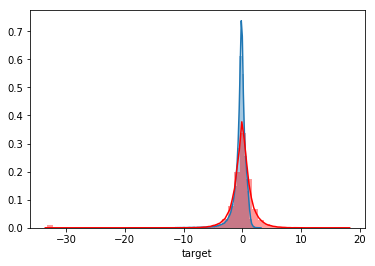

In [85]:
sns.distplot(stack_sub)
sns.distplot(train_df['target'], color='r')

In [52]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, SGDRegressor(), n_splits=10)

Fold 1 stacking valid set rmse is: 3.6096980362665163
Fold 2 stacking valid set rmse is: 3.615399261285567
Fold 3 stacking valid set rmse is: 3.6867702354861676
Fold 4 stacking valid set rmse is: 3.645737037313984
Fold 5 stacking valid set rmse is: 3.6655412338649094
Fold 6 stacking valid set rmse is: 3.6133672935783356
Fold 7 stacking valid set rmse is: 3.6596233237022178
Fold 8 stacking valid set rmse is: 3.6695087700358613
Fold 9 stacking valid set rmse is: 3.602623326547751
Fold 10 stacking valid set rmse is: 3.6723353044046942
Final stacking valid set rmse is: 3.644178854340109


In [54]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, Ridge(), n_splits=10)

Fold 1 stacking valid set rmse is: 3.6096269644238856
Fold 2 stacking valid set rmse is: 3.611903547950626
Fold 3 stacking valid set rmse is: 3.686206714061189
Fold 4 stacking valid set rmse is: 3.632962196154794
Fold 5 stacking valid set rmse is: 3.651250150786616
Fold 6 stacking valid set rmse is: 3.6041980009048906
Fold 7 stacking valid set rmse is: 3.6573859027460287
Fold 8 stacking valid set rmse is: 3.670798334522362
Fold 9 stacking valid set rmse is: 3.6026828572605933
Fold 10 stacking valid set rmse is: 3.6730900493999683
Final stacking valid set rmse is: 3.6401345571773382


In [112]:
stack_sub = stacking(oof_0, oof_1, sub_0, sub_1, train_df, HuberRegressor(), n_splits=12)

Fold 1 stacking valid set rmse is: 3.697661703324716
Fold 2 stacking valid set rmse is: 3.7006329542772893
Fold 3 stacking valid set rmse is: 3.7126060006803896
Fold 4 stacking valid set rmse is: 3.7149906989234562
Fold 5 stacking valid set rmse is: 3.72292248277529
Fold 6 stacking valid set rmse is: 3.7160512546203908
Fold 7 stacking valid set rmse is: 3.6949195950914406
Fold 8 stacking valid set rmse is: 3.713056346941837
Fold 9 stacking valid set rmse is: 3.7409307867448165
Fold 10 stacking valid set rmse is: 3.719909512927814
Fold 11 stacking valid set rmse is: 3.6967110298477333
Fold 12 stacking valid set rmse is: 3.723596721835807
Final stacking valid set rmse is: 3.7128551157099436


In [93]:
submission = pd.DataFrame()
submission['card_id'] = test_df['card_id']
submission['target'] = stack_sub
submission.to_csv('submission_stack.csv', index=False)

In [ ]:
#sub_0, 3.689
#sub_1, 3.689
## cv=3.6400189200356676 stack got 3.687

In [91]:
submission.head()

,card_id,target
201917,C_ID_0ab67a22ab,-2.459731
201918,C_ID_130fd0cbdd,-0.289961
201919,C_ID_b709037bc5,-0.725086
201920,C_ID_d27d835a9f,-0.078266
201921,C_ID_2b5e3df5c2,-1.288127


In [199]:
train_df = pd.read_hdf('Elo_result.h5', 'train_LB_3688')
test_df = pd.read_hdf('Elo_result.h5', 'test_LB_3688')


In [202]:
oof_preds, sub_preds, feature_importance_df = kfold_lightgbm(train_df, test_df, num_folds=4, params=TEST_PARAMS, stratified=True, debug=False)


Starting LightGBM. Train shape: (201917, 274), test shape: (123623, 274)
Fold 1 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.6087	test's rmse: 3.67573
[200]	train's rmse: 3.5094	test's rmse: 3.64338
[300]	train's rmse: 3.44863	test's rmse: 3.63354
[400]	train's rmse: 3.39644	test's rmse: 3.62838
[500]	train's rmse: 3.35295	test's rmse: 3.62759
[600]	train's rmse: 3.31792	test's rmse: 3.62581
[700]	train's rmse: 3.28189	test's rmse: 3.62561
[800]	train's rmse: 3.25013	test's rmse: 3.62607
[900]	train's rmse: 3.22578	test's rmse: 3.62632
[1000]	train's rmse: 3.20051	test's rmse: 3.62734
[1100]	train's rmse: 3.17911	test's rmse: 3.6273
[1200]	train's rmse: 3.15914	test's rmse: 3.62797
Early stopping, best iteration is:
[708]	train's rmse: 3.27853	test's rmse: 3.62539
Fold  1 RMSE : 3.625386
Fold 2 begins....
Training until validation scores don't improve for 500 rounds.
[100]	train's rmse: 3.59688	test's rmse: 3.69589
[200]	train's rmse: 